In [13]:
FILE_PATH = "accepted_2007_to_2018Q4.csv"

In [14]:
RANDOM_STATE = 42

In [15]:
NROWS_FULL = None       
NROWS_FAST = 200_000    
NROWS_MICRO = 50_000    

In [16]:
!pip -q install pandas numpy scikit-learn matplotlib

import os, gc, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
wanted_features = {
    "loan_amnt": "Requested principal",
    "funded_amnt": "Actually funded principal",
    "term": "Loan term (36/60 months)",
    "installment": "Monthly EMI",
    "int_rate": "Interest rate (%)",
    "annual_inc": "Annual income",
    "dti": "Debt-to-Income",
    "emp_length": "Employment tenure",
    "home_ownership": "Home ownership",
    "verification_status": "Income/Employment verified?",
    "purpose": "Loan purpose",
    "addr_state": "Borrower state",
    "revol_bal": "Revolving balance",
    "revol_util": "Revolving usage (%)",
    "open_acc": "Open accounts",
    "total_acc": "Total accounts",
    "delinq_2yrs": "Delinquencies (2 yrs)",
    "inq_last_6mths": "Credit inquiries (6 mo)",
    "pub_rec": "Derogatory public records",
    "issue_d": "Loan issue date",
    "earliest_cr_line": "Earliest credit line",
    "loan_status": "Outcome string (target source)"
}

In [18]:
hdr = pd.read_csv(FILE_PATH, compression="infer", nrows=0, low_memory=False)
available = set(hdr.columns)
feature_cols_raw = [c for c in wanted_features if c in available]

In [19]:
print(f"Total columns in file: {len(hdr.columns)}")
print(f"Using {len(feature_cols_raw)} feature columns.")
missing = [c for c in wanted_features if c not in available]
if missing:
    print("Not found (we'll proceed without these):", missing)

Total columns in file: 151
Using 22 feature columns.


In [20]:
def parse_pct(series: pd.Series) -> pd.Series:
    # "13.56%" -> 13.56
    return pd.to_numeric(series.astype(str).str.rstrip("%"), errors="coerce")

In [21]:
def parse_emp_length(series: pd.Series) -> pd.Series:
    # "10+ years" -> 10, "< 1 year" -> 0.5, "2 years" -> 2
    def _map(v):
        if pd.isna(v): return np.nan
        s = str(v).strip().lower()
        if s in ("n/a", "na", "none"): return np.nan
        if s.startswith("<"): return 0.5
        if "10+" in s: return 10.0
        # pick first number token if present
        for token in s.split():
            try: return float(token)
            except: pass
        return np.nan
    return series.apply(_map)

In [22]:
def load_data(file_path: str, usecols, nrows=None) -> pd.DataFrame:
    return pd.read_csv(
        file_path,
        compression="infer",
        usecols=usecols,
        nrows=nrows,
        low_memory=True
    )

In [23]:
def map_target(status: str) -> float:
    default_like = {
        "Charged Off", "Default",
        "Late (31-120 days)", "Late (16-30 days)",
        "Does not meet the credit policy. Status:Charged Off"
    }
    paid_like = {
        "Fully Paid",
        "Does not meet the credit policy. Status:Fully Paid"
    }
    if pd.isna(status):
        return np.nan
    s = str(status).strip()
    if s in paid_like: return 0
    if s in default_like: return 1
    return np.nan

In [24]:
df = load_data(FILE_PATH, feature_cols_raw, nrows=NROWS_FAST)  # change to NROWS_FULL later if you want
print("Loaded shape:", df.shape)

Loaded shape: (200000, 22)


In [25]:
# Clean/convert
if "int_rate" in df:     df["int_rate"] = parse_pct(df["int_rate"])
if "revol_util" in df:   df["revol_util"] = parse_pct(df["revol_util"])
if "emp_length" in df:   df["emp_length"] = parse_emp_length(df["emp_length"])

for dcol in ("issue_d", "earliest_cr_line"):
    if dcol in df:
        df[dcol] = pd.to_datetime(df[dcol], format="%b-%Y", errors="coerce")

In [26]:
# Target
df["default"] = df["loan_status"].apply(map_target)
before = len(df)
df = df[~df["default"].isna()].copy()
print(f"Kept {len(df):,} of {before:,} rows after removing ambiguous loan_status.")

Kept 177,016 of 200,000 rows after removing ambiguous loan_status.


In [27]:
# Quick EDA tables
missing_pct = (df.isna().mean().sort_values(ascending=False)*100).round(2).to_frame("missing_%")
display(missing_pct)

,missing_%
emp_length,6.31
revol_util,0.04
dti,0.00
term,0.00
int_rate,0.00
funded_amnt,0.00
loan_amnt,0.00
home_ownership,0.00
installment,0.00
issue_d,0.00


In [28]:
print("\nTarget distribution (0=paid, 1=default):")
display(df["default"].value_counts().to_frame("count").assign(pct=lambda x: (x["count"]/x["count"].sum()*100).round(2)))


Target distribution (0=paid, 1=default):


,count,pct
default,,
0.0,140992,79.65
1.0,36024,20.35


In [29]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[numeric_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
loan_amnt,177016.0,14646.231273,8618.396824,1000.00,8000.00,12500.000,20000.00,35000.00
funded_amnt,177016.0,14646.231273,8618.396824,1000.00,8000.00,12500.000,20000.00,35000.00
int_rate,177016.0,12.126318,4.237136,5.32,8.38,11.990,14.65,28.99
installment,177016.0,437.352602,254.375772,14.77,251.36,376.705,581.42,1445.46
emp_length,165841.0,6.020499,3.658815,0.50,2.00,6.000,10.00,10.00
annual_inc,177016.0,77506.600565,81512.305668,0.00,46000.00,65000.000,92000.00,9000000.00
dti,177014.0,18.922092,9.180121,0.00,12.32,18.350,25.11,999.00
delinq_2yrs,177016.0,0.346568,0.918400,0.00,0.00,0.000,0.00,30.00
inq_last_6mths,177016.0,0.583908,0.876473,0.00,0.00,0.000,1.00,5.00
open_acc,177016.0,11.884135,5.653799,1.00,8.00,11.000,15.00,82.00


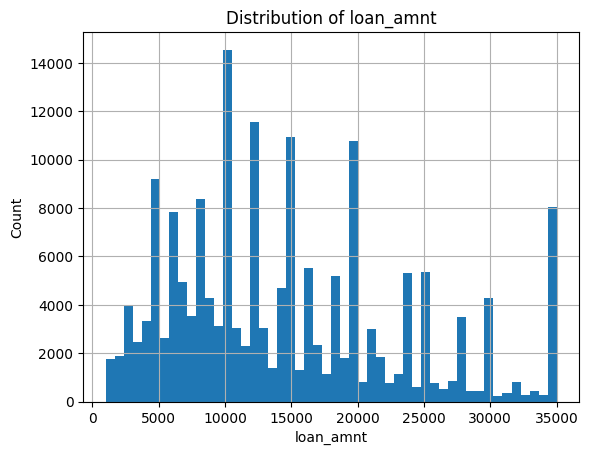

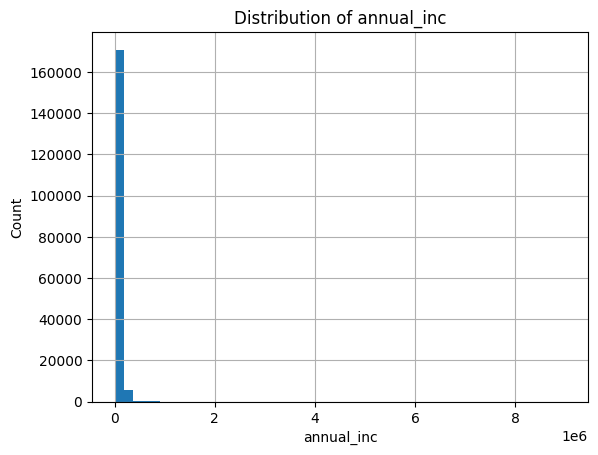

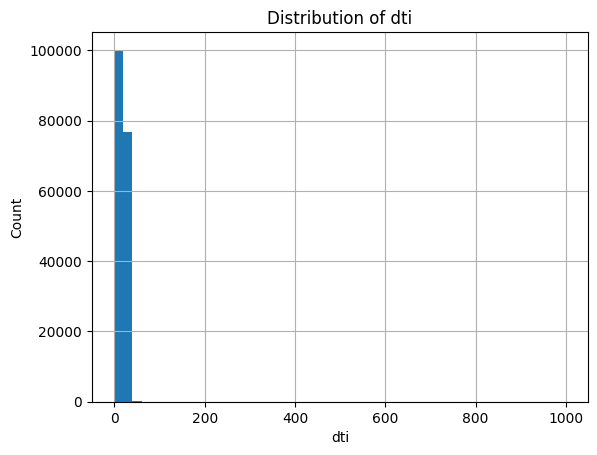

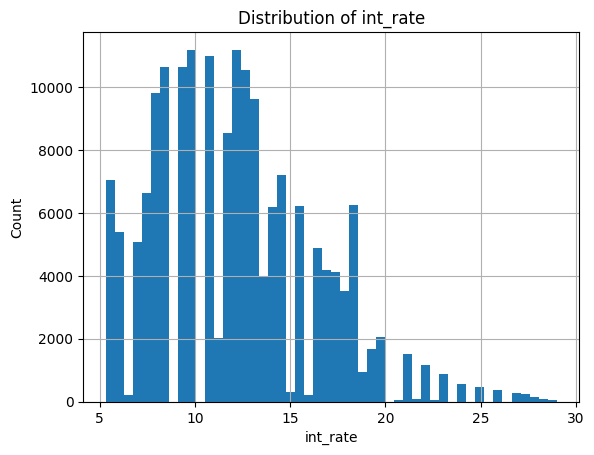

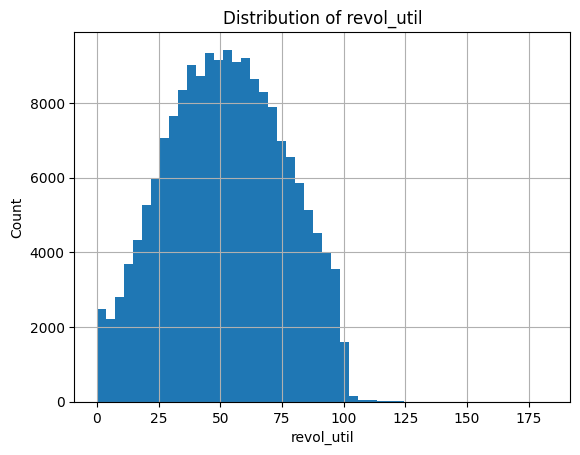

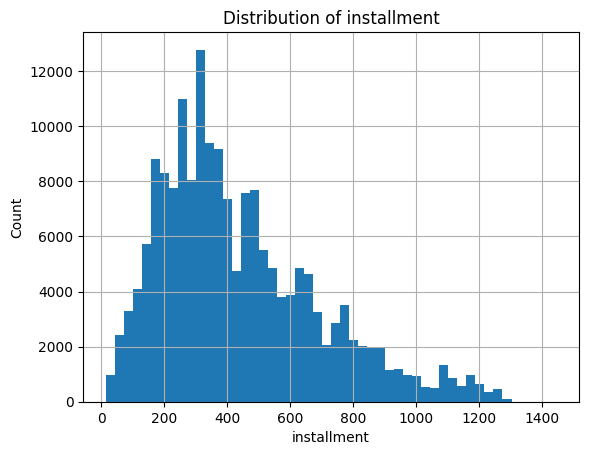

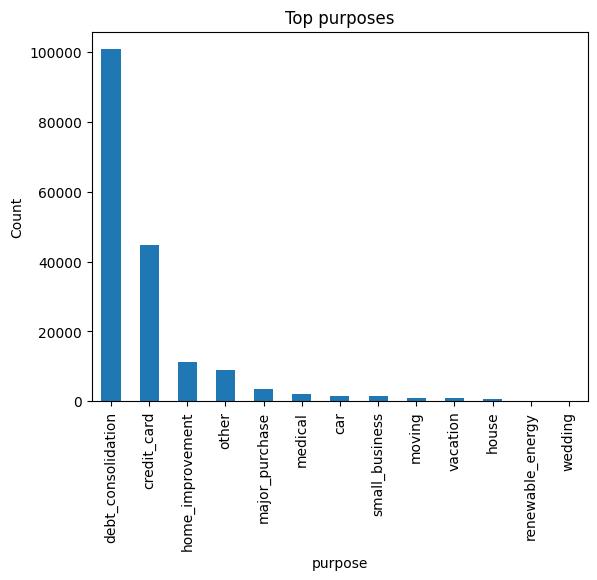

In [30]:
plot_numerics = [c for c in ["loan_amnt","annual_inc","dti","int_rate","revol_util","installment"] if c in df.columns]
for c in plot_numerics:
    ax = df[c].dropna().hist(bins=50)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.show()

if "purpose" in df.columns:
    df["purpose"].value_counts().head(15).plot(kind="bar")
    plt.title("Top purposes"); plt.xlabel("purpose"); plt.ylabel("Count")
    plt.show()

In [39]:
print("Rows after target filtering:", len(df))
if "issue_d" in df:
    print("issue_d notna %:", df["issue_d"].notna().mean())
    if df["issue_d"].notna().any():
        print("issue_d min/max:", df["issue_d"].min(), df["issue_d"].max())
print(df["default"].value_counts(dropna=False))


Rows after target filtering: 177016
issue_d notna %: 1.0
issue_d min/max: 2015-07-01 00:00:00 2015-12-01 00:00:00
default
0.0    140992
1.0     36024
Name: count, dtype: int64


In [40]:
# ----------------------------
# Cell 7 (FIXED): Feature engineering & robust split
# ----------------------------
base_features = [c for c in [
    "loan_amnt","funded_amnt","term","installment","int_rate",
    "annual_inc","dti","emp_length","home_ownership","verification_status",
    "purpose","addr_state","revol_bal","revol_util",
    "open_acc","total_acc","delinq_2yrs","inq_last_6mths","pub_rec",
    "issue_d","earliest_cr_line"
] if c in df.columns]

model_df = df[base_features + ["default"]].copy()

def add_date_features(frame: pd.DataFrame) -> pd.DataFrame:
    X = frame.copy()
    if "issue_d" in X:
        X["issue_year"] = X["issue_d"].dt.year
        X["issue_month"] = X["issue_d"].dt.month
        X["issue_ym"] = X["issue_year"]*12 + X["issue_month"]
    if "earliest_cr_line" in X:
        if "issue_d" in X:
            X["credit_hist_months"] = (
                (X["issue_d"].dt.year - X["earliest_cr_line"].dt.year)*12
                + (X["issue_d"].dt.month - X["earliest_cr_line"].dt.month)
            )
        else:
            ref = pd.Timestamp("2018-12-01")
            X["credit_hist_months"] = (
                (ref.year - X["earliest_cr_line"].dt.year)*12
                + (ref.month - X["earliest_cr_line"].dt.month)
            )
    # Drop raw datetimes after engineering
    for d in ("issue_d","earliest_cr_line"):
        if d in X.columns:
            X.drop(columns=[d], inplace=True)
    return X

# ---- Robust time-aware vs random split selection ----
def safe_time_split(mdf: pd.DataFrame, min_frac_nonnull=0.70):
    """
    Try time-aware split if issue_d exists & is mostly non-null.
    Fallback to stratified random split if not feasible or if any side ends up empty.
    """
    can_time_split = ("issue_d" in mdf.columns) and (mdf["issue_d"].notna().mean() >= min_frac_nonnull)
    if can_time_split:
        # Only use rows with non-null dates for the split logic
        temp = mdf[mdf["issue_d"].notna()].copy()
        cutoff = temp["issue_d"].quantile(0.80)
        train_idx = temp.index[temp["issue_d"] <= cutoff]
        test_idx  = temp.index[temp["issue_d"] >  cutoff]

        # Start with these, then optionally include rows with NaT (send them to train by default)
        train_df = mdf.loc[train_idx].copy()
        test_df  = mdf.loc[test_idx].copy()

        # Option: attach NaT rows to TRAIN to avoid empty sets (you can also drop them instead)
        nat_rows = mdf.index[mdf["issue_d"].isna()]
        train_df = pd.concat([train_df, mdf.loc[nat_rows]], axis=0)

        if len(train_df) > 0 and len(test_df) > 0 and train_df["default"].nunique() == 2:
            return train_df, test_df  # success

    # Fallback: stratified random split on the whole set
    tr, te = train_test_split(
        mdf, test_size=0.2, random_state=42, stratify=mdf["default"]
    )
    return tr.copy(), te.copy()

train_df, test_df = safe_time_split(model_df)

print(f"[Split] Train rows: {len(train_df):,} | Test rows: {len(test_df):,}")

# Build X/y and engineer date features
X_train_raw = train_df.drop(columns=["default"])
X_test_raw  = test_df.drop(columns=["default"])
y_train = train_df["default"].astype(int).values
y_test  = test_df["default"].astype(int).values

X_train = add_date_features(X_train_raw)
X_test  = add_date_features(X_test_raw)

# Extra safety: Ensure we didn't end up with empty sets
assert len(X_train) > 0 and len(X_test) > 0, "Empty train/test after split — check filtering earlier."
print("Shapes after feature engineering:", X_train.shape, X_test.shape)
display(X_train.head())


[Split] Train rows: 141,612 | Test rows: 35,404
Shapes after feature engineering: (141612, 23) (35404, 23)


,loan_amnt,funded_amnt,term,installment,int_rate,annual_inc,dti,emp_length,home_ownership,verification_status,purpose,addr_state,revol_bal,revol_util,open_acc,total_acc,delinq_2yrs,inq_last_6mths,pub_rec,issue_year,issue_month,issue_ym,credit_hist_months
171139,23200.0,23200.0,60 months,596.10,18.55,58000.0,30.34,10.0,MORTGAGE,Verified,debt_consolidation,GA,23351.0,79.4,9.0,19.0,2.0,1.0,0.0,2015,9,24189,289
143967,5750.0,5750.0,36 months,188.23,10.99,25000.0,38.55,10.0,RENT,Source Verified,debt_consolidation,CT,8882.0,65.3,9.0,16.0,1.0,0.0,0.0,2015,9,24189,203
121953,12000.0,12000.0,36 months,375.43,7.89,109000.0,7.42,10.0,MORTGAGE,Source Verified,debt_consolidation,IL,4712.0,28.9,7.0,34.0,0.0,0.0,1.0,2015,10,24190,341
185873,25000.0,25000.0,36 months,774.91,7.26,80000.0,29.32,10.0,MORTGAGE,Source Verified,debt_consolidation,WA,33727.0,47.7,18.0,33.0,0.0,0.0,0.0,2015,8,24188,356
68243,20000.0,20000.0,60 months,445.40,12.05,55000.0,23.70,10.0,OWN,Not Verified,credit_card,MA,13078.0,62.6,11.0,18.0,0.0,0.0,0.0,2015,11,24191,133


In [41]:
# Preprocessing pipeline (impute/encode/scale)

num_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_features = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# Fit on train, transform both
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Preprocessing complete.")
print("X_train_proc:", X_train_proc.shape, " X_test_proc:", X_test_proc.shape)


Preprocessing complete.
X_train_proc: (141612, 88)  X_test_proc: (35404, 88)


In [42]:
# Save clean artifacts for later modeling (Task 2)

# 1) A human-readable CSV (engineered features + target) BEFORE OHE/scaling:
clean_df = pd.concat([X_train.assign(default=y_train), X_test.assign(default=y_test)], axis=0)
clean_df_path = "loan_clean_subset.csv"
clean_df.to_csv(clean_df_path, index=False)

# 2) A smaller sample for quick tries
sample_rows = min(50_000, len(clean_df))
clean_sample_path = "loan_clean_sample_50k.csv"
clean_df.sample(sample_rows, random_state=RANDOM_STATE).to_csv(clean_sample_path, index=False)

# 3) A README that documents what we did
with open("EDA_Preprocessing_README.txt", "w") as f:
    f.write(textwrap.dedent(f"""
    EDA & PREPROCESSING NOTES
    -------------------------
    Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}

    Target:
      - default = 1: Charged Off, Default, Late (31-120 days), Late (16-30 days),
        Does not meet the credit policy. Status:Charged Off
      - default = 0: Fully Paid, Does not meet the credit policy. Status:Fully Paid
      - Others dropped.

    Selected features:
      {os.linesep.join([' - ' + c + ': ' + wanted_features.get(c, '(kept)') for c in wanted_features if c in clean_df.columns])}

    Cleaning:
      - Converted percent strings (int_rate, revol_util) to float
      - Parsed emp_length to numeric years
      - Parsed dates (issue_d, earliest_cr_line)
      - Engineered: issue_year, issue_month, issue_ym, credit_hist_months
      - Dropped raw date columns post-engineering

    Split:
      - Time-aware 80/20 by issue_d (older -> train, newer -> test)

    Preprocessing:
      - Numeric: median impute + StandardScaler
      - Categorical: most_frequent impute + OneHotEncoder(handle_unknown='ignore')

    Files created:
      - loan_clean_subset.csv         (engineered features + target)
      - loan_clean_sample_50k.csv     (random sample up to 50k rows)
      - EDA_Preprocessing_README.txt  (this file)
    """).strip())

print("Saved:")
print(" -", clean_df_path)
print(" -", clean_sample_path)
print(" - EDA_Preprocessing_README.txt")


Saved:
 - loan_clean_subset.csv
 - loan_clean_sample_50k.csv
 - EDA_Preprocessing_README.txt
